# qMC integration of oscillatory functions on a $d$-simplex (with warping)

In this notebook we are considering integrals of the following form,

$$
I_d(\{\alpha_1, \alpha_2, \ldots, \alpha_d\}) =
\int_0^1 du_1 \int_0^{u_1} du_2 \int_0^{u_2} du_3 \ldots \int_0^{u_{d-1}} du_d
e^{\alpha_1 u_1 + \alpha_2 u_2 + \ldots + \alpha_d u_d}.
$$
with arbitrary complex constanst $\alpha_1, \ldots, \alpha_d$.

## Reference value of the integral from SymPy

In [1]:
using SymPy

function Iref(α::Vector)
    d = length(α)
    t = [symbols("t$(n)", real = true) for n = 1:d]
    integrand = exp(sum(α .* t))
    for i = d:-1:2
        # SymPy seems to be unhappy about complex integrals of this form (bug?)
        # I have to split it into the real and imaginary parts
        integrand = integrate(real(integrand), (t[i], 0, t[i-1])) +
              1im * integrate(imag(integrand), (t[i], 0, t[i-1]))
    end
    integrate(integrand, (t[1], 0, 1)).evalf()
end

println(Iref([1.0im]))
println(Iref([1.0im, 2.0im]))
println(Iref([1.0im, 2.0im, 3.0im]))
println(Iref([1.0im, 2.0im, 3.0im, 4.0im]))
println(Iref([1.0im, -1.0im, 2.0im, -2.0im, -1.5im, 1.5im]))

0.841470984807897 + 0.45969769413186*I
0.101816569034144 + 0.397215491060637*I
-0.0732024813863645 + 0.0641428169162872*I
-0.0113049912825182 - 0.00766940477655581*I
0.00127621430262315 + 0.000276752621433472*I


## Main routines

Here, I use the notations introduced in https://arxiv.org/pdf/2002.12372.pdf.

In [2]:
import Sobol: SobolSeq, next!

# Make integrand (zero-padded outside the simplex domain)
make_f(α::Vector) = u -> (u[end] >= 0) ? exp(sum(α .* u)) : 0

# Make the model function p_n(u) out of h_i()
function make_model_function(h::Vector)
    u -> begin
        # Transformation u -> v
        v = prepend!([u[i-1] - u[i] for i = 2:length(u)], 1 - u[1])
        # Product of h(v_i)
        reduce(*, [hi(vi) for (hi, vi) in zip(h, v)])
    end
end

# Quasi Monte Carlo integration with warping
function qMCIntegrateWithWarping(f, p, p_norm, seq, trans, N::Int)
    r = 0
    for i = 1:N
        x = next!(seq)
        u = trans(x)
        r += f(u) / p(u)
    end
    r * (p_norm / N)
end

qMCIntegrateWithWarping (generic function with 1 method)

## Exponential model function

In [3]:
# Make p_d(u) from the exponential h(v)
function make_exp_model_function(τ::Real, d::Int)
    make_model_function(repeat([v -> exp(-v/τ)], d))
end

# Make the corresponding transformation x -> u
function make_exp_trans(τ::Real)
    x -> begin
        u = Vector{Real}(undef, length(x))
        u[1] = 1 + τ*log(1 - x[1])
        for i = 2:length(x)
            u[i] = u[i-1] + τ*log(1 - x[i])
        end
        u
    end
end

# Normalization of the model function P_n(u)
exp_p_norm(τ::Real, d::Int) = τ^d

exp_p_norm (generic function with 1 method)

## Visualization

In [4]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);
using HDF5

function plot_diff(N_range, vals, ref, label)
    plt.plot(N_range, abs.(vals .- ref), label = label)
    plt.xlabel("\$N\$")
    plt.ylabel("Absolute difference")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
end

plot_diff (generic function with 1 method)

In [10]:
## Power law regression

In [ ]:
using LsqFit

function N_power_law_fit(N_range, vals)
    @. power_law_model(x, p) = p[1]*(x^p[2])
    lb = [0, -1]
    ub = [Inf, -0.5]
    p0_bounds = [1.0, -0.75]
    curve_fit(model, xdata, ydata, p0_bounds, lower=lb, upper=ub)
end

$d = 2$

ref = 0.499852688774407 - 0.107927268825858*I


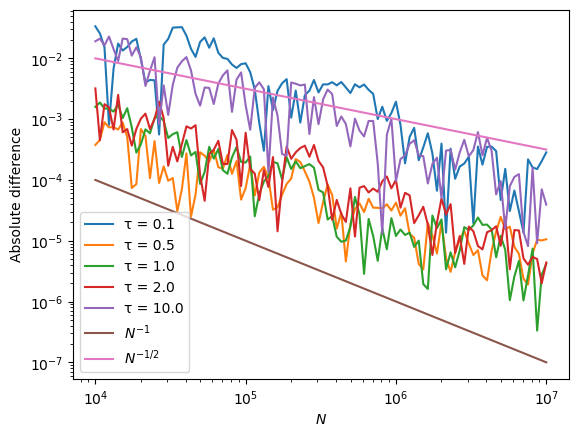

In [5]:
α = [-(2π*0.1im - 0.1), (2π*0.1im - 0.1)]
d = length(α)
f = make_f(α)

ref = Iref(α)
@show ref

τ_list = [0.1, 0.5, 1, 2, 10]
N_range = convert.(Int64, round.(exp10.(range(4, stop=7, length=100))))

vals = Array{ComplexF64, 2}(undef, (length(τ_list), length(N_range)))

for (τi, τ) in enumerate(τ_list)
    p = make_exp_model_function(τ, d)
    trans = make_exp_trans(τ)
    Threads.@threads for (Ni, N) in collect(enumerate(N_range))
        vals[τi, Ni] = qMCIntegrateWithWarping(f, p, exp_p_norm(τ, d), SobolSeq(d), trans, N)
    end
    plot_diff(N_range, vals[τi,:], ref, "τ = $τ")
end

plt.plot(N_range, collect(Float64, N_range) .^ (-1.0), label = "\$N^{-1}\$")
plt.plot(N_range, collect(Float64, N_range) .^ (-0.5), label = "\$N^{-1/2}\$")
plt.legend()

h5open("Warping.h5", "cw") do file
    g = create_group(file, "model_exp_inf_d2")
    write(g, "ref", convert(ComplexF64, ref))
    write(g, "tau_list", τ_list)
    write(g, "N_range", collect(N_range))
    write(g, "vals", vals)
end

$d  = 4$

ref = 0.0393779954336138 + 0.00451497133993306*I


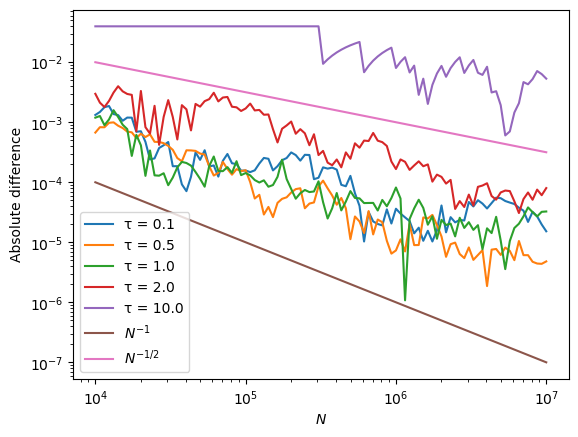

In [6]:
α = [-(2π*0.1im - 0.1), (2π*0.1im - 0.1), (2π*0.2im - 0.2), -(2π*0.2im - 0.2)]
d = length(α)
f = make_f(α)

ref = Iref(α)
@show ref

τ_list = [0.1, 0.5, 1, 2, 10]
N_range = convert.(Int64, round.(exp10.(range(4, stop=7, length=100))))

vals = Array{ComplexF64, 2}(undef, (length(τ_list), length(N_range)))

for (τi, τ) in enumerate(τ_list)
    p = make_exp_model_function(τ, d)
    trans = make_exp_trans(τ)
    Threads.@threads for (Ni, N) in collect(enumerate(N_range))
        vals[τi, Ni] = qMCIntegrateWithWarping(f, p, exp_p_norm(τ, d), SobolSeq(d), trans, N)
    end
    plot_diff(N_range, vals[τi,:], ref, "τ = $τ")
end

plt.plot(N_range, collect(Float64, N_range) .^ (-1.0), label = "\$N^{-1}\$")
plt.plot(N_range, collect(Float64, N_range) .^ (-0.5), label = "\$N^{-1/2}\$")
plt.legend()

h5open("Warping.h5", "cw") do file
    g = create_group(file, "model_exp_inf_d4")
    write(g, "ref", convert(ComplexF64, ref))
    write(g, "tau_list", τ_list)
    write(g, "N_range", collect(N_range))
    write(g, "vals", vals)
end

## Restrict $v_m$ to $[0,1]$ in the variable change induced by the product model function

Let us adopt a more economical domain $v_m\in[0,1]$ instead of $v_m\in[0,\infty)$ and rewrite the variable change (D7) from arXiv:2002.12372 as

$$
    x_m(v_m) = \frac{\int_0^{v_m} d\bar v_m h^{(m)}(\bar v_m)}
    {\int_0^1 d\bar v_m h^{(m)}(\bar v_m)}.
$$
For the exponential model $h^{(m)}_\text{exp}(v) = e^{-v/\tau}$ we get

$$
    x_m(v_m) = \frac{1 - e^{-v_m/\tau}}{1 - e^{-1/\tau}}.
$$
The normalization constant $\mathcal{C}$ for the corresponding product model function $p_m(\mathbf{u})$ is
$$
    \mathcal{C} = \int_0^1 \prod_{m=1}^d dv_m h(v_m) = (1 - e^{-1/\tau})^d \tau^d.
$$

In [7]:
# Make the corresponding transformation x -> u
function make_exp_trans_1(τ::Real)
    norm = 1 - exp(-1/τ)
    x -> begin
        u = Vector{Real}(undef, length(x))
        u[1] = 1 + τ*log(1 - norm * x[1])
        for i = 2:length(x)
            u[i] = u[i-1] + τ*log(1 - norm * x[i])
        end
        u
    end
end

# Normalization of the model function P_n(u)
exp_p_norm_1(τ::Real, d::Int) = τ^d * (1 - exp(-1/τ))^d

exp_p_norm_1 (generic function with 1 method)

$d = 2$

ref = 0.499852688774405 - 0.107927268825857*I


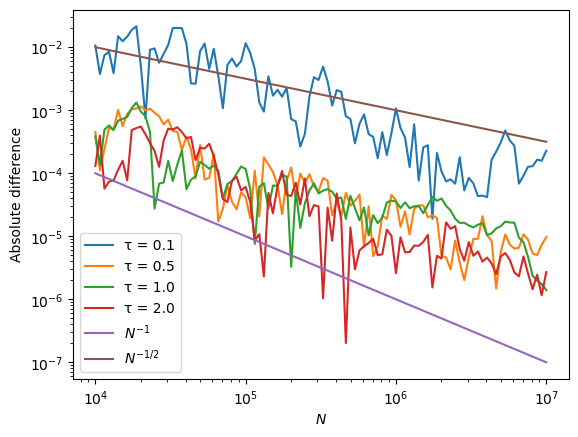

In [8]:
α = [-(2π*0.1im - 0.1), (2π*0.1im - 0.1)]
d = length(α)
f = make_f(α)

ref = Iref(α)
@show ref

τ_list = [0.1, 0.5, 1, 2]
N_range = convert.(Int64, round.(exp10.(range(4, stop=7, length=100))))

vals = Array{ComplexF64, 2}(undef, (length(τ_list), length(N_range)))

for (τi, τ) in enumerate(τ_list)
    p = make_exp_model_function(τ, d)
    trans = make_exp_trans_1(τ)
    Threads.@threads for (Ni, N) in collect(enumerate(N_range))
        vals[τi, Ni] = qMCIntegrateWithWarping(f, p, exp_p_norm_1(τ, d), SobolSeq(d), trans, N)
    end
    plot_diff(N_range, vals[τi,:], ref, "τ = $τ")
end

plt.plot(N_range, collect(Float64, N_range) .^ (-1.0), label = "\$N^{-1}\$")
plt.plot(N_range, collect(Float64, N_range) .^ (-0.5), label = "\$N^{-1/2}\$")
plt.legend()

h5open("Warping.h5", "cw") do file
    g = create_group(file, "model_exp_1_d2")
    write(g, "ref", convert(ComplexF64, ref))
    write(g, "tau_list", τ_list)
    write(g, "N_range", collect(N_range))
    write(g, "vals", vals)
end

$d=4$

ref = 0.0393779954336129 + 0.00451497133993306*I


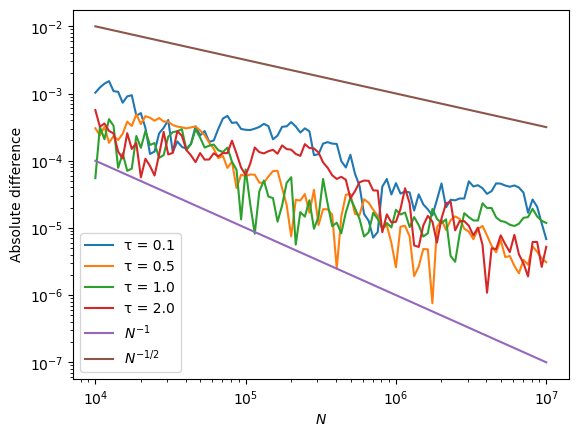

In [9]:
α = [-(2π*0.1im - 0.1), (2π*0.1im - 0.1), (2π*0.2im - 0.2), -(2π*0.2im - 0.2)]
d = length(α)
f = make_f(α)

ref = Iref(α)
@show ref

τ_list = [0.1, 0.5, 1, 2]
N_range = convert.(Int64, round.(exp10.(range(4, stop=7, length=100))))

vals = Array{ComplexF64, 2}(undef, (length(τ_list), length(N_range)))

for (τi, τ) in enumerate(τ_list)
    p = make_exp_model_function(τ, d)
    trans = make_exp_trans_1(τ)
    Threads.@threads for (Ni, N) in collect(enumerate(N_range))
        vals[τi, Ni] = qMCIntegrateWithWarping(f, p, exp_p_norm_1(τ, d), SobolSeq(d), trans, N)
    end
    plot_diff(N_range, vals[τi,:], ref, "τ = $τ")
end

plt.plot(N_range, collect(Float64, N_range) .^ (-1.0), label = "\$N^{-1}\$")
plt.plot(N_range, collect(Float64, N_range) .^ (-0.5), label = "\$N^{-1/2}\$")
plt.legend()

h5open("Warping.h5", "cw") do file
    g = create_group(file, "model_exp_1_d4")
    write(g, "ref", convert(ComplexF64, ref))
    write(g, "tau_list", τ_list)
    write(g, "N_range", collect(N_range))
    write(g, "vals", vals)
end